In [ ]:
# imports
import numpy as np
import pandas as pd
import re, os, string, typing, gc, json

In [ ]:
# loading data
path1="/content/drive/MyDrive/squad/train.json"
path2="/content/drive/MyDrive/squad/dev.json"
with open(path1, 'r', encoding='utf-8') as f:
        train_data = json.load(f)
with open(path2, 'r', encoding='utf-8') as f:
        dev_data = json.load(f)

In [ ]:
# The SQUAD data is on the drive.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Function Definitions:

In [ ]:
# Extracting the data:

def get_data(data:dict)->list:
    data = data['data']
    que_ans_list = []

    for paragraphs in data:
        for para in paragraphs['paragraphs']:
            context = para['context']

            for que_ans in para['qas']:
                
                id = que_ans['id']
                question = que_ans['question']
                
                for ans in que_ans['answers']:
                    answer = ans['text']
                    ans_start = ans['answer_start']
                    ans_end = ans_start + len(answer)
                    que_ans_dict = {}
                    que_ans_dict['id'] = id
                    que_ans_dict['context'] = context
                    que_ans_dict['question'] = question
                    que_ans_dict['label'] = [ans_start, ans_end]

                    que_ans_dict['answer'] = answer
                    que_ans_list.append(que_ans_dict)    

    return que_ans_list

## Parsing data

In [ ]:
train_data_list=get_data(train_data)
dev_data_list=get_data(dev_data)

## Data preprocessing

In [ ]:
indices=[]
word1="how"
word2="why"
for i in range(0,len(train_data_list)):
    ans_len=len(train_data_list[i]['answer'].split())
    ctxt_len=len(train_data_list[i]['context'].split())
    if ans_len>1 or ctxt_len>100 or word1 in train_data_list[i]['question'].lower() or word2 in train_data_list[i]['question'].lower():
        indices.append(i)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


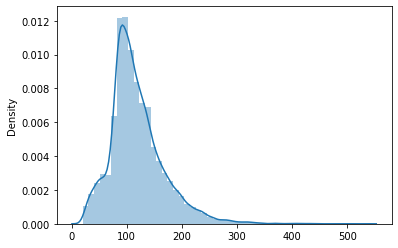

In [ ]:
# import seaborn as sns
# sns.distplot(cl)

In [ ]:
for i in range(len(indices)-1,-1,-1):
    train_data_list.pop(indices[i])

In [ ]:
for i in range(0,len(train_data_list)):
  train_data_list[i]['con_que']=train_data_list[i]['context']+' [SEP] '+train_data_list[i]['question']

In [ ]:
# for i in range(0,len(train_data_list)):
#   train_data_list[i]['que_ans']=train_data_list[i]['question']+' SEP '+train_data_list[i]['answer']

In [ ]:
df = pd.DataFrame(train_data_list)

## New approach

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from string import digits

In [ ]:
def preprocess_sentence(sentence):
    #sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    #sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

def create_dataset(qa_list, num_examples):
  lines=[]
  for i in range(0,len(qa_list)):
    lines.append(qa_list[i]['con_que']+'\t'+qa_list[i]['answer'])
  print(len(lines))
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
preprocess_sentence("Hello aren't you 20. that's really good")

'start_ hello arent you 20 .  thats really good _end'

In [ ]:
sample_size=2000
source, target = create_dataset(train_data_list,sample_size)
print(source[-1])
print(target[-1])
type(target)

10213
start_ in 1815 ,  the british government selected saint helena as the place of detention of napoleon bonaparte .  he was taken to the island in october 1815 .  napoleon stayed at the briars pavilion on the grounds of the balcombe familys home until his permanent residence ,  longwood house ,  was completed in december 1815 .  napoleon died there on 5 may 1821 .  [sep] what year did napoleon bonaparte pass away ? _end
start_ 1821 _end


tuple

In [ ]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [ ]:
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [ ]:
target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )
print(len(target_tensor[0]))

6


In [ ]:
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

6
143


In [ ]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1600 1600 400 400


In [ ]:
type(input_tensor_train)

numpy.ndarray

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ()
print ("Target Language; index to word mapping")
convert( target_sentence_tokenizer, target_train_tensor[0])

Input Language; index to word mapping
10 ----> start_
1 ----> the
671 ----> royal
630 ----> canadian
2751 ----> navy
11909 ----> (rcn)
2 ----> ,
8691 ----> headed
18 ----> by
1 ----> the
11910 ----> commander
4 ----> of
1 ----> the
671 ----> royal
630 ----> canadian
2751 ----> navy
2 ----> ,
449 ----> includes
1835 ----> 33
11911 ----> warships
6 ----> and
5270 ----> submarines
1907 ----> deployed
5 ----> in
94 ----> two
11912 ----> fleets:
3156 ----> maritime
729 ----> forces
3018 ----> pacific
11913 ----> (marpac)
31 ----> at
6735 ----> cfb
11914 ----> esquimalt
19 ----> on
1 ----> the
127 ----> west
1284 ----> coast
2 ----> ,
6 ----> and
3156 ----> maritime
729 ----> forces
575 ----> atlantic
11915 ----> (marlant)
31 ----> at
68 ----> her
8950 ----> majestys
630 ----> canadian
1225 ----> dockyard
5 ----> in
6736 ----> halifax
19 ----> on
1 ----> the
270 ----> east
1284 ----> coast
2 ----> ,
16 ----> as
124 ----> well
16 ----> as
46 ----> one
11916 ----> formation:
1 ----> the
1633 -

In [ ]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 32
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 143]), TensorShape([32, 6]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (32, 143, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 143, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 1379)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
steps_per_epoch

50

In [ ]:
# EPOCHS = 20
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    if batch_loss<0.5:
      break
    total_loss += batch_loss
    if batch % 10 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  if total_loss / steps_per_epoch <0.5:
    break

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 2.485333204269409
Epoch 1 Batch 5 loss 2.67923903465271
Epoch 1 Batch 10 loss 1.744761347770691
Epoch 1 Batch 15 loss 1.6105165481567383
Epoch 1 Batch 20 loss 1.5583428144454956
Epoch 1 Batch 25 loss 1.4441008567810059
Epoch 1 Batch 30 loss 1.2676645517349243
Epoch 1 Batch 35 loss 1.3486435413360596
Epoch 1 Batch 40 loss 1.2127103805541992
Epoch 1 Batch 45 loss 1.2759389877319336
Epoch 1 Loss 1.5735
Time taken for 1 epoch 465.14484691619873 sec

Epoch 2 Batch 0 loss 1.3832800388336182
Epoch 2 Batch 5 loss 1.3179389238357544
Epoch 2 Batch 10 loss 1.1965248584747314
Epoch 2 Batch 15 loss 1.2647531032562256
Epoch 2 Batch 20 loss 1.359142541885376
Epoch 2 Batch 25 loss 1.3191978931427002
Epoch 2 Batch 30 loss 1.1937882900238037
Epoch 2 Batch 35 loss 1.1813324689865112
Epoch 2 Batch 40 loss 1.1742109060287476
Epoch 2 Batch 45 loss 1.1878907680511475
Epoch 2 Loss 1.2563
Time taken for 1 epoch 434.09901237487793 sec

Epoch 3 Batch 0 loss 1.2130502462387085
Epoch 3 Batch 5

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate(u'I am going to work.')

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  # sentence = preprocess_sentence(sentence)
  # #print(sentence)
  # #print(source_sentence_tokenizer.word_index)

  # inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  # inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                        #  maxlen=max_source_length,
                                                        #  padding='post')
  # inputs = tf.convert_to_tensor(inputs)
  inputs=sentence
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  # print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  # attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  # plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Getting answer for a question.

translate('The last opus number that Chopin himself used was 65 allocated to the Cello Sonata in G minor He expressed a deathbed wish that all his unpublished manuscripts be destroyed At the request of the composers mother and sisters however his musical executor Julian Fontana selected 23 unpublished piano pieces and grouped them into eight further opus numbers published in 1855 In 1857 17 Polish songs that Chopin wrote at various stages of his life were collected and published as Op 74 though their order within the opus did not reflect the order of composition SEP Who grouped 23 unpublished pieces and published them as Opp in 1855')

In [ ]:
for i in input_tensor_val[100:110]:
  x=np.expand_dims(i,0)
  print([translate(x)])

Predicted translation: architect _end 
[None]
Predicted translation: prajñāpāramitā _end 
[None]
Predicted translation: endurance _end 
[None]
Predicted translation: europe _end 
[None]
Predicted translation: copper _end 
[None]
Predicted translation: france _end 
[None]
Predicted translation: 2013 _end 
[None]
Predicted translation: extinct . _end 
[None]
Predicted translation: john _end 
[None]
Predicted translation: 65 _end 
[None]


In [ ]:
for i in input_tensor_train[100:110]:
  x=np.expand_dims(i,0)
  print([translate(x)])

Predicted translation: 1924 _end 
[None]
Predicted translation: eurasia _end 
[None]
Predicted translation: paris _end 
[None]
Predicted translation: 2006 _end 
[None]
Predicted translation: sovdepia _end 
[None]
Predicted translation: copper _end 
[None]
Predicted translation: hunter-gatherers _end 
[None]
Predicted translation: peaceful _end 
[None]
Predicted translation: orthodox _end 
[None]
Predicted translation: sterilizations _end 
[None]


In [ ]:
for i in target[100:110]:
  print(i)
for i in source[100:110]:
  print(i)

start_ 7 _end
start_ 1817 _end
start_ ludwika _end
start_ szafarnia _end
start_ szafarnia _end
start_ 1828 _end
start_ zoologist _end
start_ 1829 _end
start_ french _end
start_ 1835 _end
start_ fryderyk may have had some piano instruction from his mother ,  but his first professional music tutor ,  from 1816 to 1821 ,  was the czech pianist wojciech żywny .  his elder sister ludwika also took lessons from żywny ,  and occasionally played duets with her brother .  it quickly became apparent that he was a child prodigy .  by the age of seven fryderyk had begun giving public concerts ,  and in 1817 he composed two polonaises ,  in g minor and b-flat major .  his next work ,  a polonaise in a-flat major of 1821 ,  dedicated to żywny ,  is his earliest surviving musical manuscript .  [sep] at what age did chopin start playing publicly ? _end
start_ fryderyk may have had some piano instruction from his mother ,  but his first professional music tutor ,  from 1816 to 1821 ,  was the czech pia

In [ ]:
# ! cp -r /content/training_checkpoints/checkpoint /content/drive/MyDrive/squad/checkpoints/tenepochthirtytwo

In [ ]:
# ! cp -r /content/training_checkpoints/ckpt-10.data-00000-of-00001 /content/drive/MyDrive/squad/checkpoints/tenepochthirtytwo

In [ ]:
# ! cp -r /content/training_checkpoints/ckpt-10.index /content/drive/MyDrive/squad/checkpoints/tenepochthirtytwo